In [8]:
import quake_envs
import matplotlib.pyplot as plt
import seaborn as sns
from quake_envs.simulations.building_funcs import Building, BuildingAction
from quake_envs.simulations.road_funcs import Road, RoadAction
import numpy as np
from shapely.geometry import Polygon, LineString
import matplotlib.patches as patches
import gymnasium as gym

In [9]:
building = Building(
  geometry=Polygon([(0, 0), (0, 10), (10, 10), (10, 0)]),
  id="test_building",
  occtype="COM2",
  str_type="S5L",
  num_stories=2,
  sqft=1000,
  is_essential=False,
  verbose=False,
  calc_debris=True,
  stoch_ds=True,
  stoch_rt=True,
  stoch_cost=True,
  stoch_inc_loss=True,
  stoch_loss_of_function=True,
  stoch_relocation_cost=True,
  time_step_duration=1,
)

road = Road(
  geometry=LineString([(0, 0), (0, 10), (10, 10), (10, 0)]),
  id="test_road",
  hazus_road_class="HRD1",
  verbose=False,
  calc_debris=True,
  stoch_ds=True,
  stoch_rt=True,
  stoch_cost=True,
  init_node=0,
  term_node=1,
  flow=1.0,
  capacity=1000,
  length_miles=1.0,
  hazus_bridge_class="None",
  is_bridge=False,
  time_step_duration=1,
  traffic_idx = 0
)

In [ ]:

def repair_road_and_building(road: Road, building: Building):
    is_building_repaired = False
    is_road_repaired = False
    road_repair_times = []
    road_capacity_reductions = []
    road_repair_costs = []
    road_actions = []
    building_repair_times = []
    incomes = []
    relocation_costs = []
    repair_costs = []
    building_actions = []

    while not is_building_repaired and not is_road_repaired:
        _road_repair_times, _road_capacity_reductions, _road_repair_costs, _road_actions = repair_road(road, building)
        _building_repair_times, _incomes, _relocation_costs, _repair_costs, _actions_building = repair_building(building)

        road_repair_times.extend(_road_repair_times)
        road_capacity_reductions.extend(_road_capacity_reductions)
        road_repair_costs.extend(_road_repair_costs)
        road_actions.extend(_road_actions)
        building_repair_times.extend(_building_repair_times)
        incomes.extend(_incomes)
        building_actions.extend(_actions_building)
        relocation_costs.extend(_relocation_costs)
        repair_costs.extend(_repair_costs)


        if building.current_repair_time == 0 and not building.has_debris:
            is_building_repaired = True
        if road.current_repair_time == 0:
            is_road_repaired = True

    return {
        "road_repair_times": road_repair_times,
        "road_capacity_reductions": road_capacity_reductions,
        "road_repair_costs": road_repair_costs,
        "road_actions": road_actions,
        "building_repair_times": building_repair_times,
        "incomes": incomes,
        "relocation_costs": relocation_costs,
        "repair_costs": repair_costs,
        "building_actions": building_actions
    }
def repair_building(building:Building):
    repair_times = []
    incomes = []
    relocation_cost = []
    repair_cost = []
    actions= []

    if building.has_debris or building.current_repair_time > 0:
        action = BuildingAction.REPAIR
        repair_times.append(building.current_repair_time)
        incomes.append(building.current_income)
        relocation_cost.append(building.current_relocation_cost)
        repair_cost.append(building.current_structural_repair_cost)
        building.step(action)
        actions.append(action)
    elif building.current_income != building.max_income:
        action = BuildingAction.DO_NOTHING
        repair_times.append(building.current_repair_time)
        incomes.append(building.current_income)
        relocation_cost.append(building.current_relocation_cost)
        repair_cost.append(building.current_structural_repair_cost)
        building.step(action)
        actions.append(action)


    return repair_times, incomes, relocation_cost, repair_cost, actions


def repair_road(road: Road, building: Building):
    repair_times = []
    capacity_reductions = []
    repair_costs = []
    actions = []

    if road.current_repair_time > 0:
        repair_times.append(road.current_repair_time)
        capacity_reductions.append(road.capacity_red_damage_state)
        repair_costs.append(road.current_repair_cost)
        actions.append(RoadAction.REPAIR)  # or RoadAction.DO_NOTHING if appropriate
        road.step(RoadAction.REPAIR, dependant_buildings=[building])
    return repair_times, capacity_reductions, repair_costs, actions

In [11]:
def plot_single_road_repair(road, building, figsize=(10, 6)):
    """
    Plots repair metrics over time for a single road using the `repair_road` simulation.
    """
    repair_times, capacity_reductions, repair_costs, actions = repair_road(road, building)

    timesteps = list(range(len(repair_times)))

    def normalize_to_range(values, max_val=4, min_val=None):
        min_val = min_val if min_val is not None else min(values)
        max_range = max(values) if max(values) != min_val else min_val + 1
        return [max_val * (v - min_val) / (max_range - min_val) for v in values]

    rt_norm = normalize_to_range(repair_times)
    cr_norm = normalize_to_range(capacity_reductions)
    rcost_norm = normalize_to_range(repair_costs)

    sns.set(style="whitegrid", context="notebook")
    fig, ax = plt.subplots(figsize=figsize)

    # Shaded phase regions
    try:
        t_rep = -1
        for t in repair_times:
            if t == 0.0:
                t_rep = repair_times.index(t)
                break
        t_start_repair = next(i for i, t in enumerate(repair_times) if t < max(repair_times))
    except StopIteration:
        t_start_repair = 0

    ax.axvspan(xmin=timesteps[0], xmax=len(timesteps), color='red', alpha=0.1, label='Repair Phase')

    # ax.axvspan(xmin=t_start_repair-1, xmax=len(timesteps), color='orange', alpha=0.1, label='Repair Phase')

    # Plot metrics
    ax.plot(timesteps, rt_norm, label='Repair Time', linestyle='-', marker='o')
    ax.plot(timesteps, rcost_norm, label='Repair Cost', linestyle='--', marker='^')
    ax.plot(timesteps, cr_norm, label='Capacity Reduction', linestyle='-.', marker='s')

    # Decoration
    rect = patches.Rectangle((0, 4.75), timesteps[-1], 0.5, linewidth=1, edgecolor='black', facecolor='white', zorder=25)
    ax.add_patch(rect)

    for t in timesteps:
        if actions[t] == RoadAction.REPAIR:
            ax.scatter(t, 5, s=30, marker='>', color='purple', zorder=50)
        elif actions[t] == RoadAction.DO_NOTHING:
            ax.scatter(t, 5, s=30, marker='o', color='grey', zorder=50)

    ax.set_ylim(0, 5.5)
    ax.set_title(f"Road Repair Performance Over Time", fontsize=16)
    ax.set_xlabel("Timestep", fontsize=14)
    ax.set_ylabel("Normalized Metric Value", fontsize=14)
    ax.legend()
    plt.tight_layout()
    plt.show()


In [12]:
def plot_repair_metrics(
    road_repair_times, road_capacity_reductions, road_repair_costs, road_actions,
    building_repair_times, building_incomes, building_relocation_costs, building_repair_costs, building_actions,
    building_label="Building", figsize=(14, 12)
):
    """
    Plots repair metrics over time for both a road and a building using precomputed inputs.
    """

    def normalize_to_range(values, max_val=4, min_val=None):
        min_val = min_val if min_val is not None else min(values)
        max_range = max(values) if max(values) != min_val else min_val + 1
        return [max_val * (v - min_val) / (max_range - min_val) for v in values]

    sns.set(style="whitegrid", context="notebook")
    fig, axs = plt.subplots(2, 1, figsize=figsize)

    # --- Road Plot ---
    timesteps_road = list(range(len(road_repair_times)))
    rt_norm_road = normalize_to_range(road_repair_times)
    cr_norm = normalize_to_range(road_capacity_reductions)
    rcost_norm_road = normalize_to_range(road_repair_costs)

    axs[0].axvspan(xmin=0, xmax=len(timesteps_road), color='red', alpha=0.1, label='Repair Phase')
    axs[0].plot(timesteps_road, rt_norm_road, label='Repair Time', linestyle='-', marker='o')
    axs[0].plot(timesteps_road, rcost_norm_road, label='Repair Cost', linestyle='--', marker='^')
    axs[0].plot(timesteps_road, cr_norm, label='Capacity Reduction', linestyle='-.', marker='s')

    rect = patches.Rectangle((0, 4.75), timesteps_road[-1], 0.5, linewidth=1, edgecolor='black', facecolor='white', zorder=25)
    axs[0].add_patch(rect)

    for t in timesteps_road:
        if road_actions[t] == RoadAction.REPAIR:
            axs[0].scatter(t, 5, s=30, marker='>', color='purple', zorder=50)
        elif road_actions[t] == RoadAction.DO_NOTHING:
            axs[0].scatter(t, 5, s=30, marker='o', color='grey', zorder=50)

    axs[0].set_ylim(0, 5.5)
    axs[0].set_title("Road Repair Performance Over Time", fontsize=14)
    axs[0].set_xlabel("Timestep", fontsize=12)
    axs[0].set_ylabel("Normalized Metric Value", fontsize=12)
    axs[0].legend()

    # --- Building Plot ---
    timesteps_building = list(range(len(building_repair_times)))
    rt_norm_building = normalize_to_range(building_repair_times)
    inc_norm = normalize_to_range(building_incomes)
    reloc_norm = normalize_to_range(building_relocation_costs)
    rcost_norm_building = normalize_to_range(building_repair_costs)

    try:
        t_debris_end = next(i for i, t in enumerate(building_repair_times) if t < max(building_repair_times))
        t_rep = building_repair_times.index(0.0) if 0.0 in building_repair_times else -1
    except StopIteration:
        t_debris_end = 0
        t_rep = -1

    axs[1].axvspan(xmin=0, xmax=t_debris_end - 1, color='orange', alpha=0.1, label='Debris Clearing Phase')
    if t_rep != -1:
        axs[1].axvspan(xmin=t_debris_end - 1, xmax=t_rep - 1, color='red', alpha=0.1, label='Repair Phase')
        axs[1].axvspan(xmin=t_rep - 1, xmax=len(timesteps_building) - 1, color='green', alpha=0.1, label='Recovery Phase')
    else:
        axs[1].axvspan(xmin=t_debris_end - 1, xmax=len(timesteps_building), color='red', alpha=0.1, label='Repair Phase')

    axs[1].plot(timesteps_building, rt_norm_building, label='Repair Time', linestyle='-', marker='o')
    axs[1].plot(timesteps_building, rcost_norm_building, label='Repair Cost', linestyle='--', marker='^')
    axs[1].plot(timesteps_building, inc_norm, label='Income', linestyle=':', marker='d')
    axs[1].plot(timesteps_building, reloc_norm, label='Relocation Cost', linestyle='-.', marker='x')

    rect = patches.Rectangle((0, 4.75), timesteps_building[-1], 0.5, linewidth=1, edgecolor='black', facecolor='white', zorder=25)
    axs[1].add_patch(rect)

    for t in timesteps_building:
        # print(building_actions)
        # print(len(building_actions))
        # print(t)
        if building_actions[t] == BuildingAction.REPAIR:
            axs[1].scatter(t, 5, s=30, marker='>', color='purple', zorder=50)
        elif building_actions[t] == BuildingAction.DO_NOTHING:
            axs[1].scatter(t, 5, s=30, marker='o', color='grey', zorder=50)

    axs[1].set_ylim(0, 5.5)
    axs[1].set_title(f"Building: {building_label} Repair Performance Over Time", fontsize=14)
    axs[1].set_xlabel("Timestep", fontsize=12)
    axs[1].set_ylabel("Normalized Metric Value", fontsize=12)
    axs[1].legend()

    plt.tight_layout()
    plt.show()


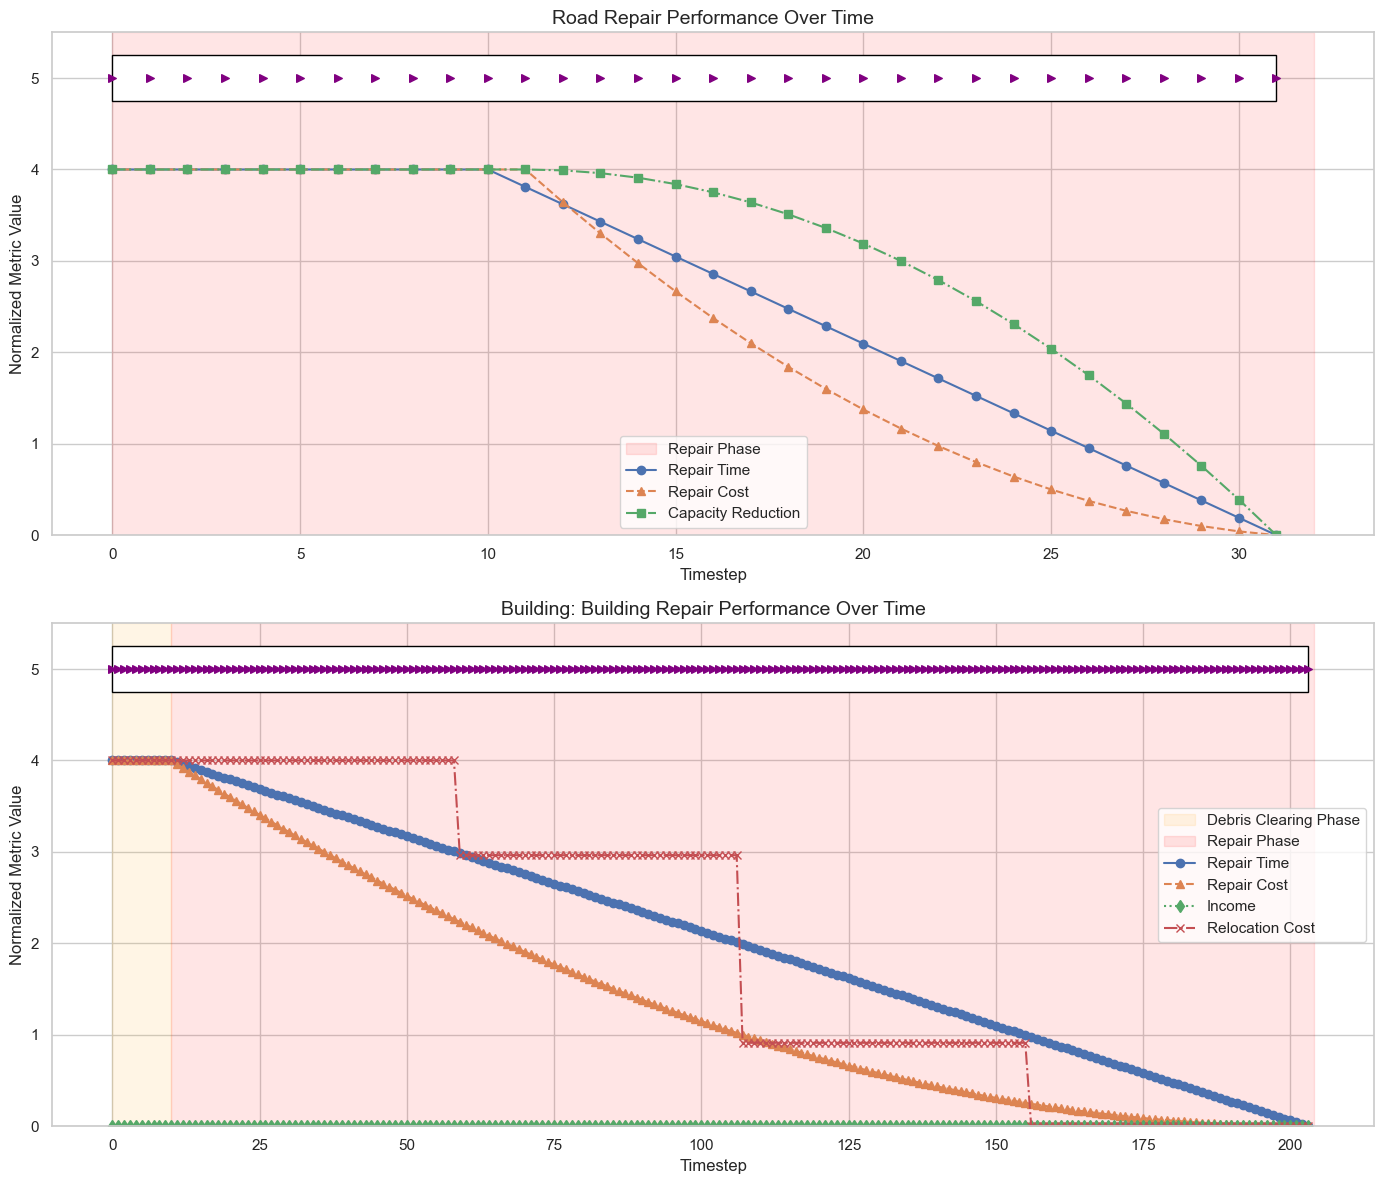

In [13]:
building.reset(damage_state_probs=np.array([0.0, 0.0, 0.0, 0.0, 1.0]), debris_capacity_reduction=1.0)
road.reset(damage_state = 2, capacity_red_debris=1.0)

plotting_data = repair_road_and_building(road, building)
# print(plotting_data["building_actions"])
# print(plotting_data)
plot_repair_metrics(
    plotting_data["road_repair_times"], plotting_data["road_capacity_reductions"], plotting_data["road_repair_costs"], plotting_data["road_actions"],
    plotting_data["building_repair_times"], plotting_data["incomes"], plotting_data["relocation_costs"], plotting_data["repair_costs"], plotting_data["building_actions"]
)